In [3]:
import scipy.io
import os
import scipy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from sklearn.metrics import jaccard_score
import random
from torch_geometric.nn import GCNConv
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import average_precision_score
from torch_geometric.datasets import Yelp

## load data

In [5]:
def import_yelp(shuffle_idx):

    data_name = "yelp"
    path = "data/yelp/"
    print('Loading dataset ' + data_name + '...')
    dataset = Yelp(root='../../tmp/Yelp')

    data = dataset[0]
    # removed small classes if there is
    labels = torch.load(path + "yelp_clean_lbl.pt")
    features = data.x
    edge_index = data.edge_index

    class_order = torch.load(path + "yelp_" + shuffle_idx + ".pt")
    groups = torch.load(path + "groups" + shuffle_idx[-1] + ".pt")
    # splits is a nested dictionary
    # key: groups, value: (key:train, val, test; value:node_ids)
    # splits = pd.read_pickle(r'../data/groups_splits.pkl')
    splits = torch.load(path + "split_" + shuffle_idx[-1] + ".pt")

    num_nodes = labels.shape[0]

    G = Data(x=features,
             edge_index=edge_index,
             y=labels)
    G.n_id = torch.arange(num_nodes)
    G.splits = splits
    G.groups = groups
    G.class_order = class_order

    return G
G1 = import_yelp("shuffle1")
G2 = import_yelp("shuffle2")
G3 = import_yelp("shuffle3")

Loading dataset yelp...
Loading dataset yelp...
Loading dataset yelp...


## check data

## Comparison of the homophily on subgraphs and static graph

In [6]:
from torch_geometric.utils import mask
from torch_geometric.utils import subgraph

def flatten(nested_data):
    for i in nested_data:
        if isinstance(i, (list, tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i
def map_edge_index(node_ids, edge_index_complete):
    # input the node_id in the complete graph, transform the edge_index into the subgraph index
    num_edge = edge_index_complete.shape[1]
    map_book = {x.item(): i for i, x in enumerate(node_ids)}
    edge_index_mapped = map(lambda node: map_book[node], np.asarray(edge_index_complete.flatten()))
    edge_index = torch.Tensor(list(edge_index_mapped))
    edge_index = torch.reshape(edge_index, (2, num_edge)).long()

    return edge_index
def map_split(node_ids, split):
    # map the split ids into the subgraph
    map_book = {x.item(): i for i, x in enumerate(node_ids)}

    mapped_split = {}
    for key in split.keys():
        mapped_split[key] = list(map(lambda node: map_book[node], np.asarray(split[key])))

    return mapped_split
            
def prepare_sub_graph(G, key, Cross_Task_Message_Passing=False):
    # prepare subgraph for one task, used both for TaskIL and ClassIL
    # target classes for each task, note for catastrophic forgetting evaluation
    target_classes = list(flatten(key))
    # sorted nodes ids in the group
    node_ids_g = torch.Tensor(G.groups[key]).int().long()

    # build node mask from the ids for the subgraph
    node_mask = mask.index_to_mask(node_ids_g, size=G.num_nodes)

    # allow nodes from other task to pass information to the nodes for this task
    if Cross_Task_Message_Passing:
        # or operation of two boolean lists
        edge_mask = node_mask[G.edge_index[0]] + node_mask[G.edge_index[1]]
        edge_index_g = G.edge_index[:, edge_mask]
        # all nodes in the subgraph(including target nodes and their neighbors) in the original graph
        node_ids_g_all = torch.unique(edge_index_g.flatten()).long()
        # index of target nodes in the graph
        target_ids_g = [i for i, n in enumerate(node_ids_g_all) if n in node_ids_g]

        # !!!!!!!!!!!!!convert target id into the subgraph !!!!!!!!!!!!!!!!!!!
        # evaluate only on the target nodes!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #target_ids_sub =
        # get the edge_index in the subgraph
        edge_index_sub = map_edge_index(node_ids_g_all, edge_index_g)

    # only nodes of this task in the subgraph
    else:
        # edge index in the original graph
        edge_index_g, _ = subgraph(node_ids_g, G.edge_index, None)
        # all neighbors are in the subgraph already
        node_ids_g_all = node_ids_g
        # all nodes are target nodes
        target_ids_g = node_ids_g_all
        # node ids in the subgraph
        target_ids_sub = np.arange(node_ids_g_all.shape[0])
        # edge index in the subgraph
        edge_index_sub = map_edge_index(node_ids_g_all, edge_index_g)

    features = G.x[node_ids_g_all]
    labels = G.y[node_ids_g_all]
    # map the ids to subgraph
    split = map_split(node_ids_g_all, G.splits[key])
    # number of nodes in the subgraph
    num_nodes = node_ids_g_all.shape[0]

    sub_g = Data(x=features,
                 edge_index=edge_index_sub,
                 y=labels)

    # node id in the subgraph
    sub_g.n_id_sub = torch.arange(num_nodes)
    # node id in the original graph
    sub_g.n_id_original = node_ids_g_all
    sub_g.split = split
    sub_g.target_classes = target_classes
    # target ids in the sub graph
    sub_g.target_ids_sub = target_ids_sub
    # target ids in the original graph
    sub_g.taget_ids_g = target_ids_g

    return sub_g

In [7]:
# homophily of each subgraph
Gs = [G1, G2, G3]
homos = []
clus = []
for G in Gs:
    for key in list(G.groups.keys()):
        sub_g = prepare_sub_graph(G, key)
        #homo ratio

        support = 0.0
        edges = torch.transpose(sub_g.edge_index, 0, 1)
        print("number of edges: ", int(edges.shape[0]/2), "number of nodes: ", len(G.groups[key]))
        col = list(key)
        labels = sub_g.y[:, col]
        for i, edge in enumerate(edges):
            support = support + jaccard_score(labels[edge[0].item()],
                                              labels[edge[1].item()])
        h = support / edges.shape[0]
        # clustering coefficient
        networkX_graph = to_networkx(sub_g, node_attrs=["x"])

        #print("subgraph:", key)
        #print("homophily of the subgraph",np.round(h, 5))
        homos.append(np.round(h, 5))
        #print("clustering coefficient", np.round(nx.average_clustering(networkX_graph), 5))
        clus.append(np.round(nx.average_clustering(networkX_graph), 5))
print(len(homos))
print(np.mean(homos))
print("###################################")
edges = torch.transpose(G.edge_index, 0, 1)
labels = G.y
support = 0.0
for i, edge in enumerate(edges):
    support = support + jaccard_score(labels[edge[0].item()],
                                      labels[edge[1].item()])
h = support / edges.shape[0]

networkX_graph = to_networkx(G, node_attrs=["x"])
print("original graph, homophily",np.round(h, 5), "clustering coefficient", np.round(nx.average_clustering(networkX_graph), 5))

number of edges:  979422 number of nodes:  138821


KeyboardInterrupt: 

### sum all edges in the subgraphs 33019 edges, there might be duplicates
### while in the original static graph there is 37351 edges

Graph with 759 nodes and 3257 edges
Graph with 425 nodes and 1103 edges
Graph with 299 nodes and 719 edges
Graph with 631 nodes and 4581 edges
Graph with 568 nodes and 1868 edges
Graph with 1317 nodes and 8054 edges
Graph with 1573 nodes and 13437 edges


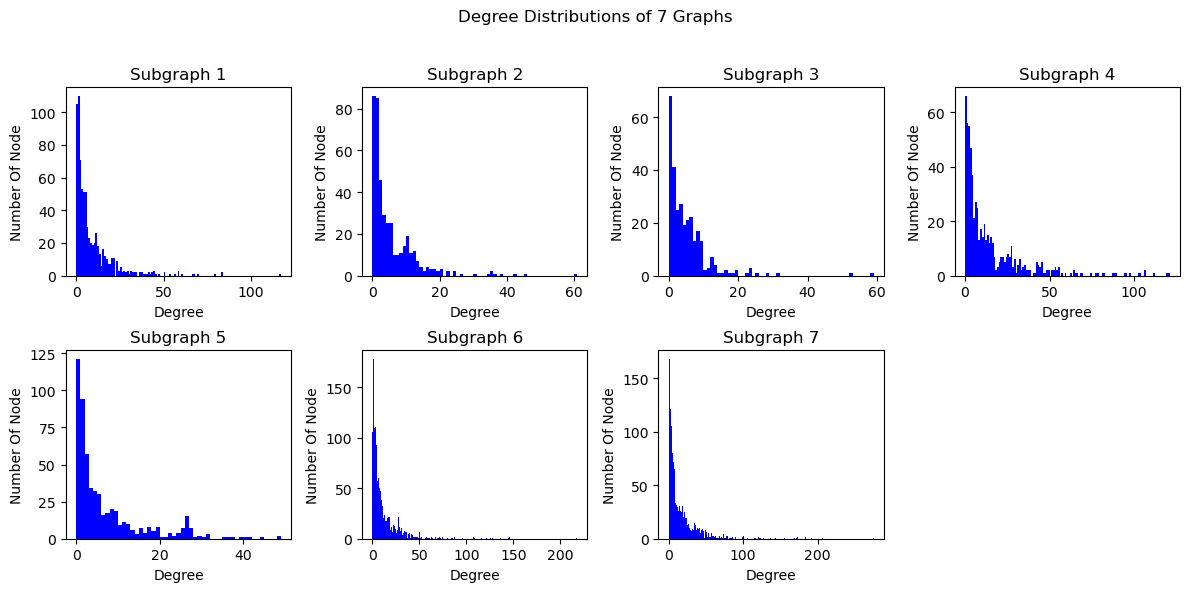

In [61]:
# Create a 2x4 grid of subplots for the degree distributions
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Degree Distributions of 7 Graphs')

for i, key in enumerate(list(G.groups.keys())):
    if i < 7:
        sub_g = prepare_sub_graph(G, key)
        edges = torch.transpose(sub_g.edge_index, 0, 1).tolist()

        # remove the redundancy
        edges = list(set(tuple(sorted(edge)) for edge in edges))
        edges = [list(edge) for edge in edges]

        nodes = range(len(G.groups[key]))
        # Create a graph from the edge list
        nx_G = nx.Graph()
        nx_G.add_nodes_from(nodes)
        nx_G.add_edges_from(edges)
        nx_G = nx_G.to_undirected()
        print(nx_G)
        # Calculate degrees
        degrees = [nx_G.degree(node) for node in nx_G.nodes()]

        # Plot degree distribution on the corresponding subplot
        ax = axes[i // 4, i % 4]
        ax.hist(degrees, bins=max(degrees), color='blue', )
        ax.set_title(f'Subgraph {i + 1}')
        ax.set_xlabel('Degree')
        ax.set_ylabel('Number Of Node')
        
# del the last blank plot
fig.delaxes(axes[7 // 4, 7 % 4])
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

TypeError: cannot convert dictionary update sequence element #0 to a sequence

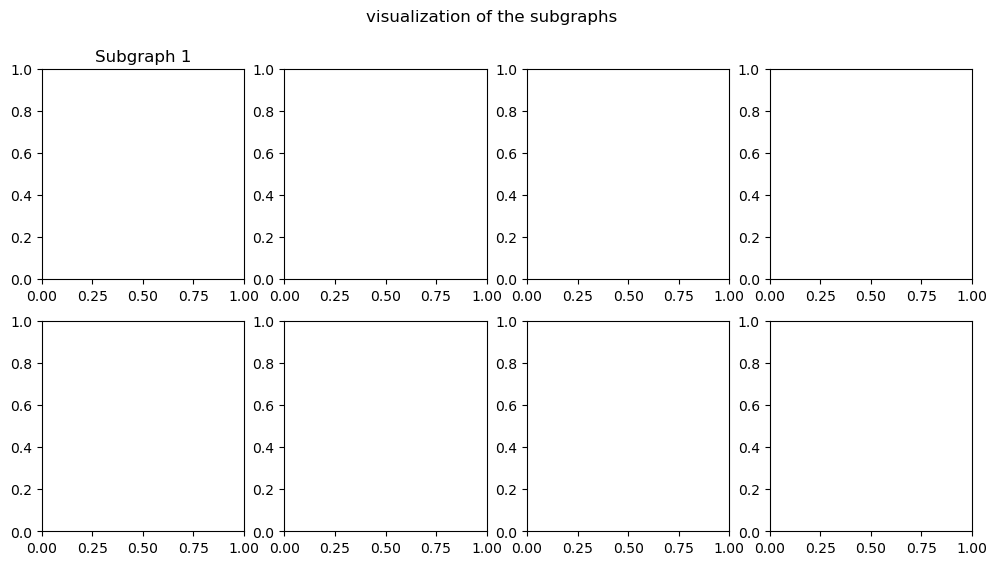

In [72]:
# Create a 2x4 grid of subplots for the degree distributions
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('visualization of the subgraphs')

for i, key in enumerate(list(G.groups.keys())):
    if i < 7:
        sub_g = prepare_sub_graph(G, key)
        edges = torch.transpose(sub_g.edge_index, 0, 1).tolist()

        # remove the redundancy
        edges = list(set(tuple(sorted(edge)) for edge in edges))
        edges = [list(edge) for edge in edges]

        nodes = list(range(len(G.groups[key])))
        # Create a graph from the edge list
        nx_G = nx.Graph()
        nx_G.add_nodes_from(nodes)
        nx_G.add_edges_from(edges)
        nx_G = nx_G.to_undirected()
        
        # Choose the position in the subplot grid
        row = i // 4
        col = i % 4

        # Draw the graph on the corresponding subplot
        axes[row, col].set_title(f'Subgraph {i + 1}')
        nx.draw(G, ax=axes[row, col], with_labels=True, node_size=300, 
                node_color='skyblue', edge_color='black')
      
        #ax.set_title(f'Subgraph {i + 1}')
        
# del the last blank plot
fig.delaxes(axes[7 // 4, 7 % 4])
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

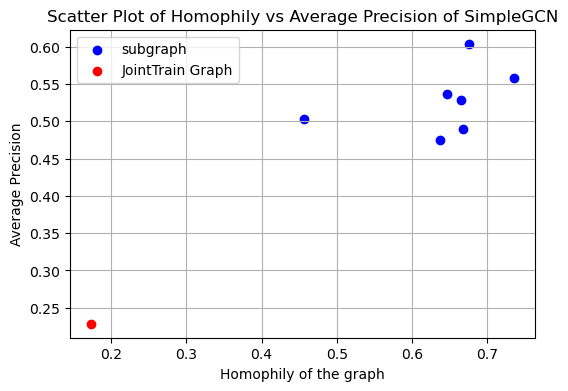

In [107]:
#plot the average performance vs the homophily ratio
homo = [0.73549, 0.66727, 0.637, 0.64626, 0.66435, 0.67594, 0.45686]
ap = [0.55750, 0.48940, 0.47490, 0.53710, 0.52810, 0.60390, 0.50280]
overall_homo=[0.17396]
overall_ap = [0.2285]

# Create the scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(homo, ap, c='b', marker='o', label='subgraph')
plt.scatter(overall_homo, overall_ap, c='r', marker='o', label='JointTrain Graph')
# Set labels and title
plt.xlabel('Homophily of the graph')
plt.ylabel('Average Precision')
plt.title('Scatter Plot of Homophily vs Average Precision of SimpleGCN')

# Add grid
plt.grid(True)

# Show legend
plt.legend()

# Show the plot
plt.show()

## Why does JointTrain Perform So Bad?
- on single labeled node: is the neighbothood too diverse?
- on the super-labled node: neighbors too few?

### the neighborhood of the most labeled node in the graph

In [9]:
# check the direct neighborhood of the multi-labeled data

# find the most labeled data

row_sums = torch.sum(G.y, axis=1)
print(row_sums.shape)
max_sum_row = torch.argmax(row_sums)
print("node index", max_sum_row )
print("label of the node", G.y[max_sum_row])

torch.Size([3233])
node index tensor(1880)
label of the node tensor([1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.])


In [10]:
edges1880 = np.where(G.edge_index[0] == 1880)[0]
# Print the neighbors
print("Neighbors of node 1880 are nodes:", G.edge_index[1][edges1880])

Neighbors of node 1880 are nodes: tensor([ 111,  112,  166,  192,  252,  257,  326,  363,  416,  417,  433,  452,
         460,  485,  548,  565,  583,  614,  620,  710,  712,  914,  932,  951,
         994,  995,  997, 1008, 1009, 1010, 1019, 1059, 1106, 1121, 1147, 1169,
        1209, 1260, 1262, 1304, 1443, 1449, 1477, 1480, 1481, 1483, 1486, 1506,
        1507, 1508, 1509, 1511, 1512, 1513, 1514, 1579, 1617, 1674, 1730, 1753,
        1777, 1778, 1780, 1781, 1782, 1805, 1809, 1843, 1851, 1872, 1874, 1881,
        1882, 1883, 1914, 1937, 1956, 1975, 1992, 2050, 2073, 2088, 2089, 2097,
        2112, 2122, 2141, 2206, 2270, 2415, 2508, 2545, 3159, 3170])


In [11]:
neighbors = G.edge_index[1][edges1880]
label_neighbors = G.y[neighbors]
label1880 =  G.y[1880]

torch.Size([15])


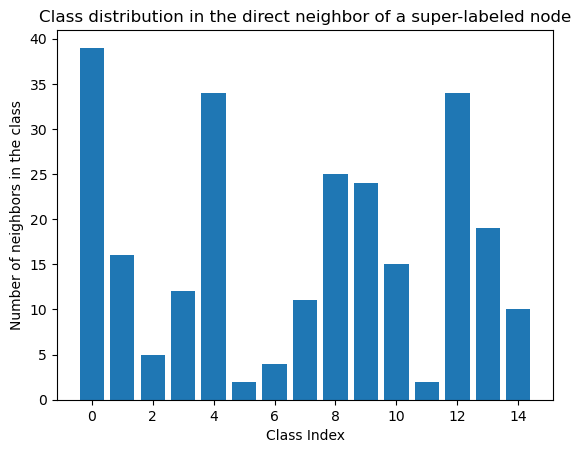

In [12]:
column_sums = label_neighbors.sum(dim=0)
print(column_sums.shape)
# Convert the column sums to a NumPy array for visualization
column_sums_np = column_sums.numpy()

# Create x-axis values (column indices)
x = range(column_sums_np.shape[0])

# Plot the column sums
plt.bar(x, column_sums_np)
plt.xlabel('Class Index')
plt.ylabel('Number of neighbors in the class')
plt.title('Class distribution in the direct neighbor of a super-labeled node')
plt.show()

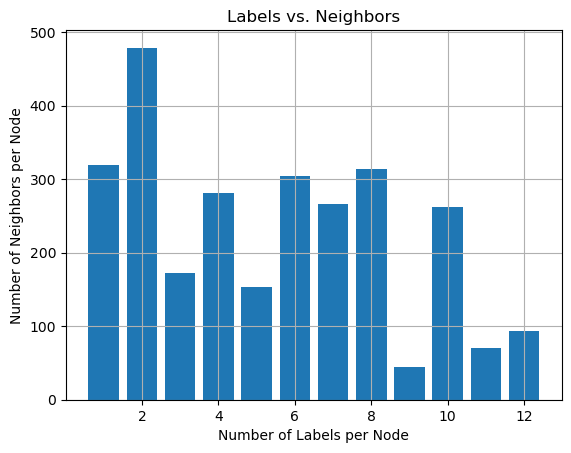

In [108]:
# number of neighbors and number of labels

# Count the number of neighbors for each node
num_neighbors = torch.bincount(G.edge_index[0])

# Count the number of labels each node has
num_labels = torch.sum(G.y, dim=1).int()

# Create a bar plot
plt.bar(num_labels, num_neighbors)
plt.xlabel('Number of Labels per Node')
plt.ylabel('Number of Neighbors per Node')
plt.title('Labels vs. Neighbors')
plt.grid(True)
plt.show()

In [110]:
num_neighbors.shape

torch.Size([3233])

In [115]:
torch.max(num_labels)

tensor(12, dtype=torch.int32)

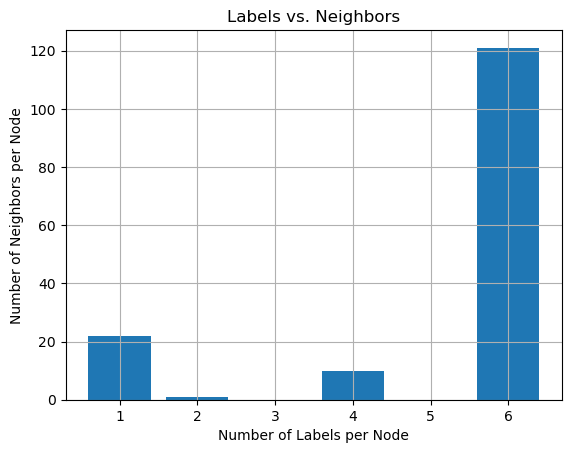

In [113]:
plt.bar(num_labels[:5], num_neighbors[:5])
plt.xlabel('Number of Labels per Node')
plt.ylabel('Number of Neighbors per Node')
plt.title('Labels vs. Neighbors')
plt.grid(True)
plt.show()

### observation: 
- low level multi-labeled nodes are the most connected
- single labeled nodes are very connected in the graph

### neighborhood of the single labeled nodes

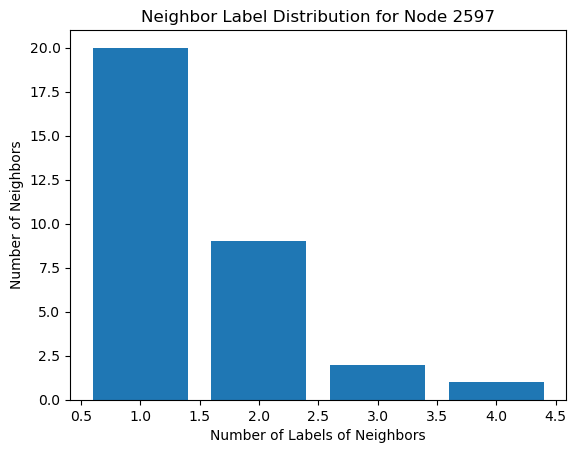

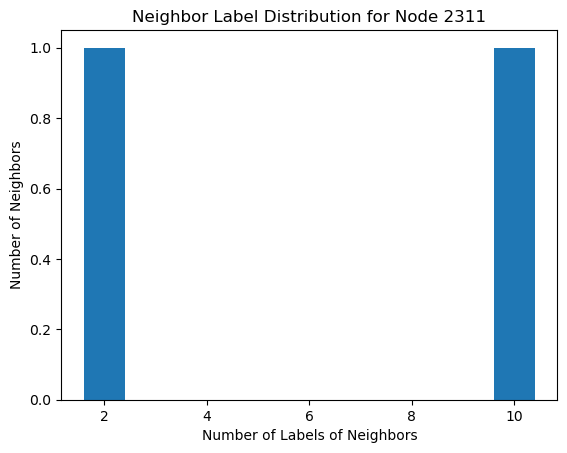

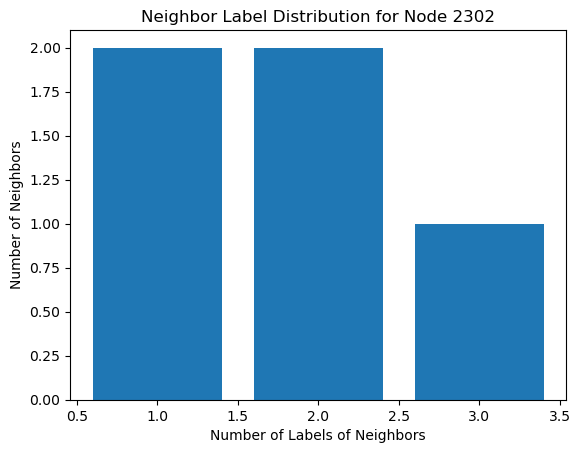

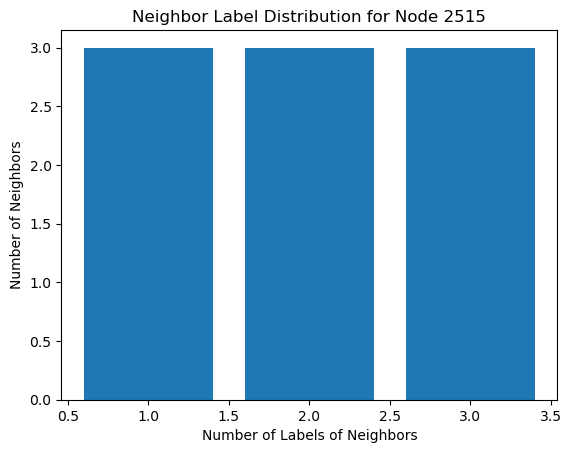

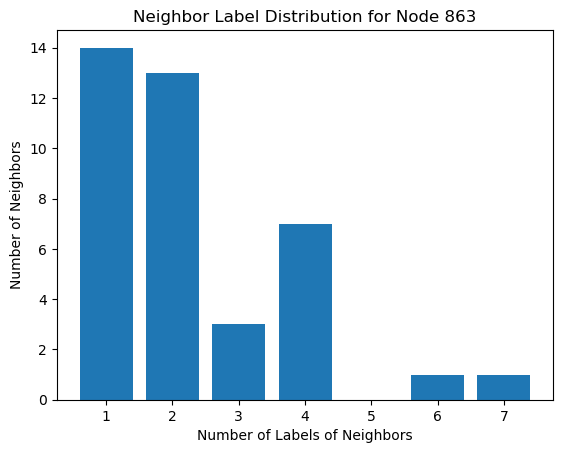

In [15]:
# Step 1: Get indices of nodes with one label
nodes_with_one_label = torch.where(G.y.sum(dim=1) == 1)[0]

# Step 2: Randomly select 5 nodes
selected_nodes = random.sample(nodes_with_one_label.tolist(), 5)

# Initialize dictionaries to store neighbor label counts
neighbor_label_counts = {node: {} for node in selected_nodes}

# Step 3 and Step 4: For each selected node, get neighbors and count their labels
for node in selected_nodes:
    neighbors = G.edge_index[1, G.edge_index[0] == node]
    for neighbor in neighbors:
        labels = G.y[neighbor].numpy().astype(int)
        num_labels = labels.sum()
        if num_labels in neighbor_label_counts[node]:
            neighbor_label_counts[node][num_labels] += 1
        else:
            neighbor_label_counts[node][num_labels] = 1

# Step 5: Create a histogram for each selected node
for node in selected_nodes:
    x = list(neighbor_label_counts[node].keys())
    y = list(neighbor_label_counts[node].values())
    
    plt.figure()
    plt.bar(x, y)
    plt.xlabel('Number of Labels of Neighbors')
    plt.ylabel('Number of Neighbors')
    plt.title(f'Neighbor Label Distribution for Node {node}')
    plt.show()


### Overall label assignment in the graph 

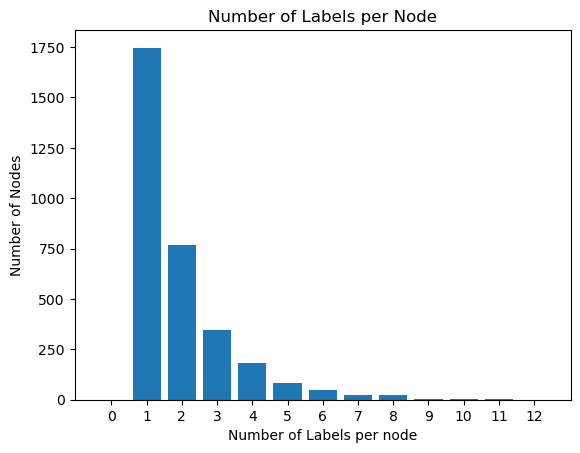

In [16]:
# Count the number of labels each node has
num_labels_per_node = torch.sum(G.y, dim=1).int()
# Count the frequency of each number of labels
label_counts = torch.bincount(num_labels_per_node)
# Create a bar plot
plt.bar(range(len(label_counts)), label_counts, tick_label=range(len(label_counts)))
plt.xlabel('Number of Labels per node')
plt.ylabel('Number of Nodes')
plt.title('Number of Labels per Node')
plt.show()

## what kind of nodes get good scores vs what kind of nodes get bad score?

### load the joint trained model on shuffle 2

In [17]:

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, multi_class=False):
        super(GCN, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.multi_class = multi_class

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # the representations before convert to probabilities
        # used for ergnn sampler
        self.rep = x
        if self.multi_class:
            m = torch.nn.Softmax()
        else:
            m = torch.nn.Sigmoid()
        return m(x)

    def add_new_outputs(self, num_new_classes):
        # Add new output units for each new class
        in_channels = self.conv2.in_channels
        out_channels = self.conv2.out_channels + num_new_classes
        new_conv2 = GCNConv(in_channels, out_channels)

        # the parameters trained for the old tasks copied to the new defined layer
        paras = [para for para in self.conv2.parameters()]
        # extend with random values and pack as iter to give to new conv2
        # the in and out dimensions are extent
        bias = torch.randn(out_channels)
        weight = torch.randn(out_channels, in_channels)
        for i, para in enumerate(paras):
            # bias
            if i == 0:
                bias[:self.conv2.out_channels] = para
            # weight
            else:
                weight[:self.conv2.out_channels] = para
        paras_new = {"bias": bias,
                     "lin.weight": weight}
        new_conv2.load_state_dict(paras_new)

        self.conv2 = new_conv2
        
model = GCN(in_channels=G.x.shape[1],
                hidden_channels=64,
                out_channels=G.y.shape[1])

model.load_state_dict(torch.load("JointTrainGCN_JointTrain_pcg_removed_isolated_nodes_shuffle2_checkpoint.pt"))

<All keys matched successfully>

In [18]:
splits = torch.load("data/pcg_removed_isolated_nodes/" + "JointTrain_split_" + "2" + ".pt")
G.split = splits

In [19]:
def ap_score(y_true, y_pred):
    ap_score = average_precision_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())

    return ap_score

In [30]:
out = model.forward(G.x, G.edge_index)
y = G.y

ap_test_nodes = []
for test_node in G.split["test"]:
    ap_test = ap_score(y[test_node], out[test_node])
    ap_test_nodes.append(ap_test)

In [40]:
np.mean(ap_test_nodes)

0.4982626838157599

In [42]:
ap_test_overall = ap_score(G.y[G.split["test"]], out[G.split["test"]])
ap_test

0.2285494060303518

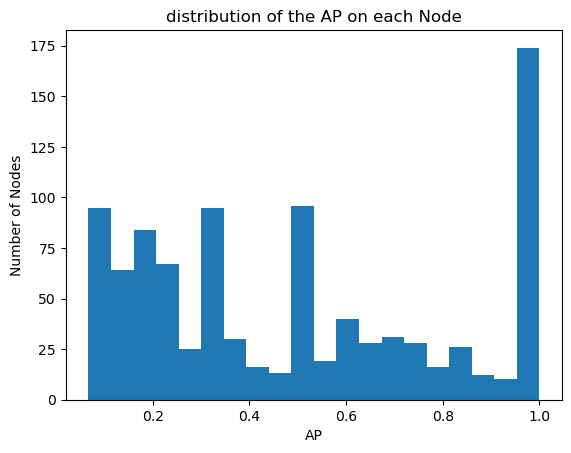

In [63]:
# distribution of the scores
plt.hist(ap_test_nodes, bins=20)
plt.xlabel('AP')
plt.ylabel('Number of Nodes')
plt.title('distribution of the AP on each Node')
plt.show()

In [95]:
# from the worst performing to the best performing nodes, rank the indices of the test node
threshold = np.mean(ap_test_nodes)
#threshold = 1.0
worse_indices = [index for index, element in enumerate(ap_test_nodes) if element < threshold]
better_indices = [index for index, element in enumerate(ap_test_nodes) if element >= threshold]

In [96]:
num_labels_worse_ind = torch.sum(G.y[worse_indices], axis=1)
num_labels_better_ind = torch.sum(G.y[better_indices], axis=1)
print(num_labels_worse_ind.shape)
print(num_labels_better_ind.shape)

torch.Size([490])
torch.Size([479])


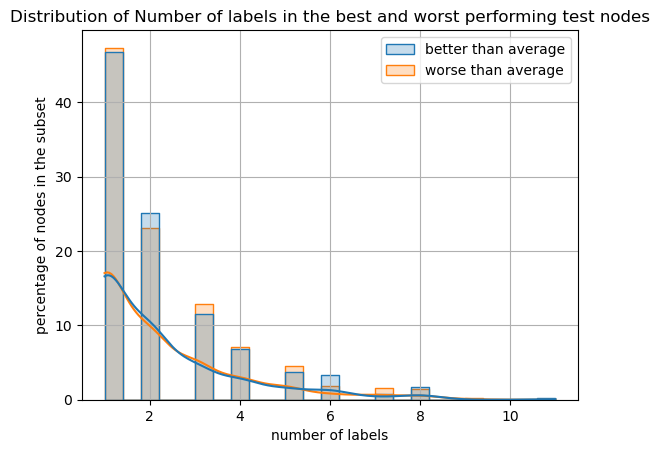

In [117]:
# Create a combined dataset and labels
data = {'better than average': num_labels_better_ind, 'worse than average': num_labels_worse_ind}

# Create a histogram with different colors
sns.histplot(data=data, kde=True, element="step", common_norm=False, stat="percent")
plt.title('Distribution of Number of labels in the best and worst performing test nodes')
plt.xlabel('number of labels per node')
plt.ylabel('percentage of nodes in the subset')
plt.grid()
plt.show()

### the homophily ratio around SINGLE-LABELED worse performing nodes

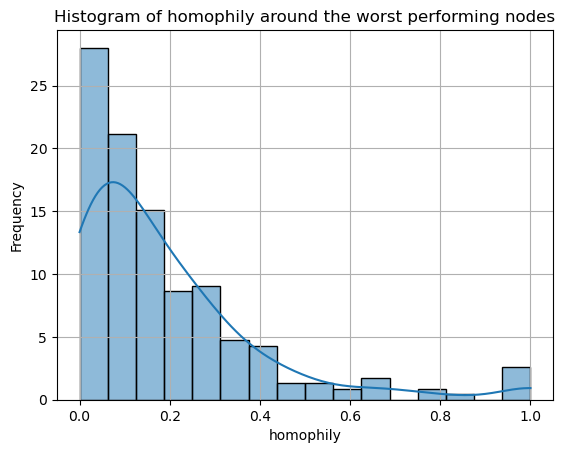

In [102]:
# get the neighbor of the nodes
homo_average_worse_nodes = []
for node in worse_indices:
    if torch.sum(G.y[node]) == 1:
        neighbors = G.edge_index[1, G.edge_index[0] == node].tolist()

        support = 0.0
        for i, neighbor in enumerate(neighbors):
            support = support + jaccard_score(G.y[node],
                                              G.y[neighbor])
        h = support / len(neighbors)
        homo_average_worse_nodes.append(h)
    
sns.histplot(homo_average_worse_nodes, kde=True, stat="percent")  # kde=True adds a kernel density estimate
plt.title('Histogram of homophily around the worst performing nodes')
plt.xlabel('homophily')
plt.ylabel('Frequency')
plt.grid()
plt.show()

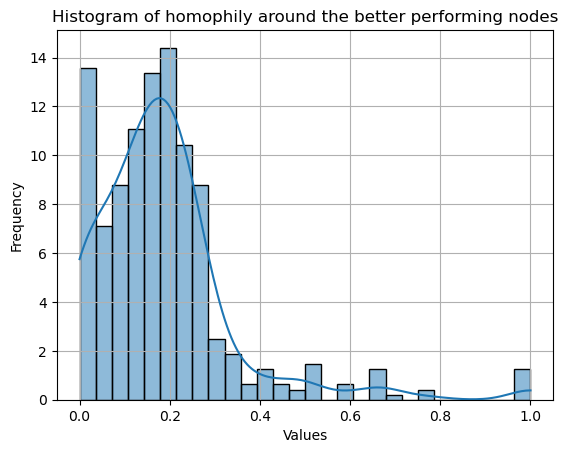

In [103]:
# get the neighbor of the nodes
homo_average_better_nodes = []
for node in better_indices:
    neighbors = G.edge_index[1, G.edge_index[0] == node].tolist()
    
    support = 0.0
    for i, neighbor in enumerate(neighbors):
        support = support + jaccard_score(G.y[node],
                                          G.y[neighbor])
    h = support / len(neighbors)
    homo_average_better_nodes.append(h)
sns.histplot(homo_average_better_nodes, kde=True, stat="percent")  # kde=True adds a kernel density estimate
plt.title('Histogram of homophily around the better performing nodes')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid()
plt.show()

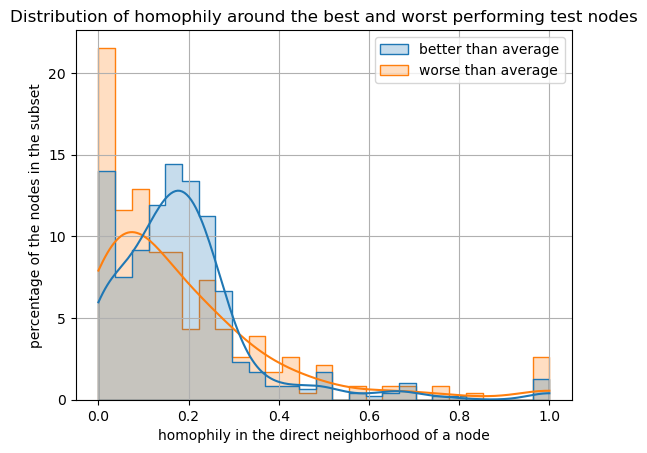

In [119]:
data = {'better than average': homo_average_better_nodes, 'worse than average': homo_average_worse_nodes}
# Create a histogram with different colors
sns.histplot(data=data, kde=True, element="step", common_norm=False, stat="percent")
plt.title('Distribution of homophily around the best and worst performing test nodes')
plt.xlabel('homophily in the direct neighborhood of a node')
plt.ylabel('percentage of the nodes in the subset')
plt.grid()
plt.show()

### two options:

- find better lower and upper bound

### or

- allow nodes with seen labels from the previous tasks 

In [ ]:
# performance and number of labels

# Create a scatter plot
plt.scatter(num_labels_per_node, ap_test_nodes)
plt.xlabel('Number of Labels per Node')
plt.ylabel('average precision')
plt.title('Scatter Plot of number of Labels vs. performance')
plt.grid(True)
plt.show()

In [ ]:
sub_g

In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx
networkX_graph = to_networkx(sub_g, node_attrs=["x"])
nx.average_clustering(networkX_graph)

In [ ]:
#homo ratio
import numpy as np
from sklearn.metrics import jaccard_score
support = 0.0
edges = torch.transpose(sub_g.edge_index, 0, 1)
col = [2, 10]
labels = sub_g.y[:, col]
for i, edge in enumerate(edges):
    support = support + jaccard_score(labels[edge[0].item()],
                                      labels[edge[1].item()])
h = support / edges.shape[0]
h

In comparison Cora

In [ ]:
from torch_geometric.datasets import Planetoid
import os.path as osp
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'Planetoid')
dataset = Planetoid(path, "cora", transform=T.NormalizeFeatures())
data = dataset[0].to(device)